# Questions about the real data

## What is the density of GAIA stars across the sky ?

## Find GAIA pairs with proper motions consistent with single lensing

## Are all DR2 stars already in DR1 [is it just basically better measurements ?]

## Questions about both DR1 and DR2 data

### positional accuracy

### time baseline

### proper motion measurements

# Analysis strategies

## mag/demag ratio limits acceptable lens/image geometries


In [61]:
## define some constants

c = 3e8 # speed of light [m/s]
G = 6.67e-11 # gravitational constant [m^3/Kg/sec/sec]
Ms = 1.989e30 # mass of sun [kg]
Mj = 1.898e27 # masss of jupiter [kg]
pc_m =  3.086e16 # parsec in units of meters


## define some utility functions

import math
import pandas as pd
import numpy as np
import ggplot as gg

def D_eff_pc(D_L_pc, D_S_pc) :
    """
effective lensing distance is harmonic difference of distances

1/D_eff = 1/D_Lens - 1/D_Source
    """
    return 1/(1/D_L_pc - 1/D_S_pc)

def R_einstein_mas(m_L_kg, D_L_pc, D_S_pc) :
    """
einstein radius for a lensed point source

    Radius_einstein_ring  = (4 G / c^2) m (1/D_L - 1/D_S)
    
    """
    D_pc = D_eff_pc(D_L_pc, D_S_pc)
    return 1000*60*60*math.degrees(math.sqrt( (4 * G / c / c / pc_m ) *
                                         m_L_kg  / D_eff_pc(D_L_pc, D_S_pc)) )

def quadadd(a,b) : return math.sqrt(a*a + b*b)
def hyperadd(a) : return (a + 1/a)

def sma_mas(S_mas, L_mas, Re_mas) :
    """
    
    compute lens/src/image ellipse semi major axis
    
    """
    return (quadadd(S_mas - L_mas, 2*Re_mas)/2.0)


def I_mas(S_mas, L_mas, m_L_kg, D_L_pc, D_S_pc) :
    """
    compute positions lensed image assuming the ordering is
    I_l < L < S < I_r
        
    I_l and I_r are the solutions for I in
    (I-S)(I-L) = thetaE^2 = 4 G m (1/d_l - 1/d_s) / c / c
    
    I*I - (S+L)I + S*L - thetaE^2 = 0
    2*I = S+L +/- sqrt( (S+L)^2 - 4*(S*L - thetaE^2) )
        2*I = S+L +/- sqrt( (S-L)^2 + 4*thetaE^2 )
        
        thetaE^2 = 4 G m D_eff_pc / c / c
                 = R_einstein_mas^2
                 
    **The images are the vertices of an ellipse with the source and lens at the foci
    and the einstein ring diameter as the minor axis.**

    """
    Re = R_einstein_mas(m_L_kg, D_L_pc, D_S_pc)
    sma = sma_mas(S_mas,L_mas, Re)
    centroid    = (S_mas + L_mas)/2
    return centroid-sma, L_mas, S_mas, centroid+sma

def mag_y(S_mas, L_mas, Re_mas) :
    return ((S_mas - L_mas)/ Re_mas)

def mags(yv) :
    """
    compute magnification of I_l and I_r images.  Note that
    I_r becomes S in the limit of no lensing.
    mu_ = 0.5 + y^2+2 / 2y / sqrt(y^2+4)
    y = S_mas-L_mas
    """
    y = np.divide(yv['SmL'],yv['Er'])
    totalmag = hyperadd(y/math.sqrt(2)) / math.sqrt(2*hyperadd(y/2)) /  math.sqrt(2*y)

    yv['yval'] = y
    #yv['mag_l'] = totalmag - 0.5
    #yv['mag_r'] = totalmag + 0.5
    #yv['magratio'] = (totalmag + 0.5)/(totalmag-0.5)
    yv['dmag_l'] = 2.5 * math.log10(totalmag - 0.5)
    yv['dmag_r'] = 2.5 * math.log10(totalmag + 0.5)
    #yv['dmag'] = 2.5 * math.log10(yv['magratio'])
    return yv
# just a reminder of the type of the input data
#from plotnine import *
from plotnine.data import *
#print(ggplot(mtcars, aes(x='hp',y='wt',color='mpg')) + geom_point())
#print(ggplot(mtcars) + geom_point(aes(x='hp',y='wt',color='mpg'), size = 3))


In [62]:
## some order of magnitude checks and intuition guides

pdin = pd.Series([[3.9,], [3.9,]], index = ['SmL', 'Er'])
print(pdin)

print("effective lens distance[pc] ", D_eff_pc(1,50))
print("einstein radius[mas]        ", R_einstein_mas(Mj, 0.5, 30))
print("I_ L S I^ positions[mas]    ", I_mas(10, 2, Mj, 0.5, 30))
display('magval =                  ', mags(pdin))


SmL    [3.9]
Er     [3.9]
dtype: object
effective lens distance[pc]  1.0204081632653061
einstein radius[mas]         3.9058207896483945
I_ L S I^ positions[mas]     (0.4093438631186048, 2, 10, 11.590656136881396)


'magval =                  '

SmL          [3.9]
Er           [3.9]
yval         [1.0]
dmag_l    -1.91865
dmag_r    0.171226
dtype: object

,SmL,key,Er,yval,dmag_l,dmag_r
0,0.01,0.0,0.01,1.000000,-1.918651,0.171226
1,0.01,0.0,1.12,0.008929,4.360765,4.380153
2,0.01,0.0,2.23,0.004484,5.113316,5.123053
3,0.01,0.0,3.34,0.002994,5.553539,5.560041
4,0.01,0.0,4.45,0.002247,5.865884,5.870764


,SmL,key,Er,yval,variable,value
0,0.01,0.0,0.01,1.000000,dmag_l,-1.918651
1,0.01,0.0,1.12,0.008929,dmag_l,4.360765
2,0.01,0.0,2.23,0.004484,dmag_l,5.113316
3,0.01,0.0,3.34,0.002994,dmag_l,5.553539
4,0.01,0.0,4.45,0.002247,dmag_l,5.865884


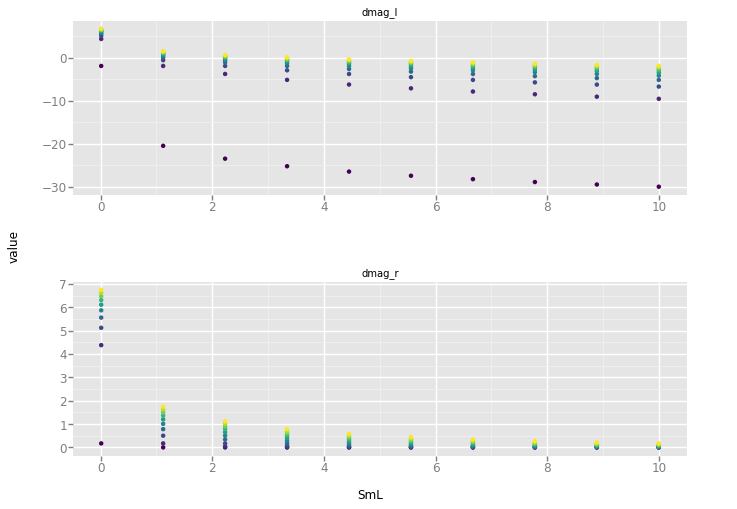

<ggplot: (8768114892520)>


In [71]:

yvals = np.linspace(0.2,0.8,10)
asa = pd.DataFrame({'yval' : yvals, 'SmL' : np.linspace(0.01,10,10), 'Er' : np.linspace(2,3,10)})

# need to outer join a range of values of SmL and Er
asa  = pd.DataFrame({'SmL' : np.linspace(0.01,10,10)
                     ,'key' : np.zeros(10)
                    }).merge(
       pd.DataFrame({'Er' : np.linspace(0.01,10,10)
                     , 'key': np.zeros(10)
                    }), how = 'outer')

themags = asa.apply(mags, axis = 1)
display(themags.head())


#gg.ggplot(themags.reset_index(), gg.aes(x = 'yval', y = 'mag_l')) + gg.geom_point()
#print(gg.ggplot(gg.aes(), data = themags)
# + gg.geom_point(gg.aes(x = 'yval', y = 'mag_l'), color = 'green')
# + gg.geom_point(gg.aes(x = 'yval', y = 'mag_r'), color = 'red')
# )

mthemags = themags.melt(id_vars = ('SmL','key','Er','yval'))
display(mthemags.head())

#print(gg.ggplot(gg.aes(), data = mthemags)
# + gg.geom_point(gg.aes(x = 'SmL', y = 'value', color = 'Er'))
# + gg.facet_grid('SmL', 'Er', scales = 'free')
# )

print(gg.ggplot(gg.aes(), data = mthemags)
 + gg.geom_point(gg.aes(x = 'SmL', y = 'value', color = 'Er'))
 + gg.facet_wrap('variable', scales = 'free')
 )


# Insights so far

## For source/lens/image geometry:   I_l   L   S   I_r

### At source distance from lens of about 1/3 of Einstein ring radius, I_l is at nominal brightness while I_r is magnified by 2.  As source moves further from lens, both I_l and I_r are further demagnified.  I_l goes to zero while I_r goes to one.

### for a source too close to the lens, both images should be visible separated by about an einstein ring diameter

### so, I_r is the 'primary' image.  I_l is the secondary image [because its always fainter]
## plot I_l-I_r separation and relative magnitude as a function of S/L separation
## need:   S_pos, E_r
max source lens separation can be limited because of the implied mag/demag of the images.
##
